In [1]:
# Required libraries
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from pycop import archimedean, estimation, gaussian, student, simulation, mixture
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data set
df = pd.read_csv("FinDataSet-1.csv")
df.index = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.head()

,Date,CBA,MQG
Date,,,
2013-01-02,2/1/2013,73.134,38.539
2013-01-03,3/1/2013,72.636,37.851
2013-01-04,4/1/2013,72.188,38.235
2013-01-07,7/1/2013,70.754,42.394
2013-01-08,8/1/2013,71.362,43.368


In [3]:
# Current values of financial variables
current_values = df.tail(1).to_numpy()
CBA_price = current_values[0,1]
MQG_price = current_values[0,2]

In [4]:
# Price data
price_df = df.copy()

# Drop other columns
df = df.drop(["Date"], axis=1)

# Calculate the daily log-return:
for col in df.columns.values:
    df.loc[:,col] = np.log(df.loc[:,col]) - np.log(df.loc[:,col].shift(1))

df = df.dropna()
df.head()

,CBA,MQG
Date,,
2013-01-03,-0.006833,-0.018013
2013-01-04,-0.006187,0.010094
2013-01-07,-0.020065,0.103256
2013-01-08,0.008556,0.022715
2013-01-09,-0.019299,0.011486


In [5]:
# Covariance matrix of (daily) log returns
daily_log_ret_cov = np.cov(df, rowvar = False)
daily_log_ret_cov

CBA_ann_vol = np.sqrt(daily_log_ret_cov[0,0] * 250)
MQG_ann_vol = np.sqrt(daily_log_ret_cov[1,1] * 250)

# Portfolio Value

## The entire portfolio value:

$$ V_t = V_{\text{CBA},t} + V_{\text{MQG},t} $$

Where each position value as follows:
$$\begin{align*}
V_{\text{CBA}, t} &= V_{\text{call}, 80} \left( t, S_{CBA,t}, r_t^{(6m)} \right) + V_{\text{call}, 110} \left( t, S_{CBA,t}, r_t^{(6m)} \right) - 2 \times V_{\text{call}, 100} \left( t, S_{CBA,t}, r_t^{(6m)} \right) \\[5pt]
V_{\text{MQG}, t} &= V_{\text{put}, 150} \left( t, S_{MQG,t}, r_t^{(6m)} \right) + V_{\text{call}, 220} \left( t, S_{MQG,t}, r_t^{(6m)} \right)
\end{align*}$$

# 1. Use the Black-Scholes-Merton formula to determine the mark-to-market value

In [6]:
# Pricing function for European calls and puts
def BSprice(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility, option_type):
    
    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility
    
    # Calculate d1 and d2
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    # Calculate option prices
    if option_type == 'call':
        price = (np.exp(-q * tau) * s * sp.stats.norm.cdf(d1, 0.0, 1.0) \
                 - np.exp(-r * tau) * K * sp.stats.norm.cdf(d2, 0.0, 1.0))
        
    if option_type == 'put':
        price = (np.exp(-r * tau) * K * sp.stats.norm.cdf(-d2, 0.0, 1.0) \
                 - np.exp(-q * tau) * s * sp.stats.norm.cdf(-d1, 0.0, 1.0))
        
    return price

In [7]:
# Assign values:
rfr = 0.0267
tau = 0.5
dy = 0

# Butterfly spread CBA:
CBA_l_call_strike_80 = 80
CBA_l_call_strike_110 = 110
CBA_s_call_strike_100_x2 = 100

# Strangle MQG:
MQG_l_put_strike_150 = 150
MQG_l_call_strike_220 = 220

# Calculate the mark-to-market value of the butterfly spread:
bs_CBA_long_1 = BSprice(CBA_price, CBA_l_call_strike_80, tau, rfr, dy, CBA_ann_vol, "call")
bs_CBA_long_2 = BSprice(CBA_price, CBA_l_call_strike_110, tau, rfr, dy, CBA_ann_vol, "call")
bs_CBA_short_3 = - 2 * BSprice(CBA_price, CBA_s_call_strike_100_x2, tau, rfr, dy, CBA_ann_vol, "call")
bs_value = bs_CBA_long_1 + bs_CBA_long_2 + bs_CBA_short_3

# Calculate the mark-to-market value of the strangle:
st_MQG_long_1 = BSprice(MQG_price, MQG_l_put_strike_150, tau, rfr, dy, MQG_ann_vol, "put")
st_MQG_long_2 = BSprice(MQG_price, MQG_l_call_strike_220, tau, rfr, dy, MQG_ann_vol, "call")
st_value = st_MQG_long_1 + st_MQG_long_2

In [8]:
print(bs_CBA_long_1)
print(bs_CBA_long_2)
print(bs_CBA_short_3)
print(bs_value)

print(st_MQG_long_1)
print(st_MQG_long_2)
print(st_value)

57.80795551621756
50.10402500659926
-104.87192106017369
3.0400594626431285
2.0312532665039953
3.069401220849919
5.100654487353914


# 2. Implement meethods from (M1) to (M5)

## Risk Factor Mapping

We introduce the following notation:

$$
\mathbf{Z}_t := \begin{bmatrix} Z_{1,t} \\ Z_{2,t} \end{bmatrix} = \begin{bmatrix} \ln S_{CBA,t} \\ \ln S_{MQG,t}  \end{bmatrix}, \quad \mathbf{X}_{t+1} := \mathbf{Z}_{t+1} - \mathbf{Z}_t = \begin{bmatrix} \ln S_{CBA,t+1} - \ln S_{CBA,t} \\ \ln S_{MQG,t+1} - \ln S_{MQG,t} \end{bmatrix}
$$

A mapping, therefore, of the risk factor vector Zt to the current portfolio value is
$$\begin{align*}
V_t &= g(t, \mathbf{Z}_t) \\[5pt]
&:= V_{\text{CBA}} \left( t, e^{Z_{1,t}} \right) + V_{\text{MQG}} \left( t, e^{Z_{2,t}} \right).
\end{align*}$$

## 2.1. (M1) Analytical delta-normal approach

In [9]:
# Create dataframe to store value
portfolio_risk_measures = pd.DataFrame(columns=['method', 'position', 'time_period', 'conf_level', 'risk_measure'])

# Confidence level
conf_level_list = [0.9, 0.95, 0.99]

In [10]:
# Function to calculate option delta under the Black-Scholes-Merton model
def BSdelta(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility, option_type):
    
    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility
    
    # Calculate d1 and d2
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    
    # Calculate option delta
    if option_type == 'call':
        value = sp.stats.norm.cdf(d1, 0.0, 1.0)
    
    if option_type == 'put':
        value = sp.stats.norm.cdf(d1, 0.0, 1.0) - 1
    
    return value    

In [11]:
def delta_approx(CBA_price, MQG_price, CBA_ann_vol, MQG_ann_vol): 
    # Call Option Risk Factor Exposures
    # - Call delta
    call_delta_CBA_80 = BSdelta(CBA_price, CBA_l_call_strike_80, tau, 
                         rfr, dy, CBA_ann_vol, option_type = 'call')
    call_delta_CBA_110 = BSdelta(CBA_price, CBA_l_call_strike_110, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol, option_type = 'call')
    call_delta_CBA_100_x2 = BSdelta(CBA_price, CBA_s_call_strike_100_x2, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol, option_type = 'call')
    
    call_delta_MQG_220 = BSdelta(spot_price = MQG_price, strike_price = MQG_l_call_strike_220, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = MQG_ann_vol, option_type = 'call')
    
    # Put Option Risk Factor Exposures
    # - Put delta
    put_delta_MQG_150 = BSdelta(spot_price = MQG_price, strike_price = MQG_l_call_strike_220, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = MQG_ann_vol, option_type = 'put')
    
    # Butterfly Spread Risk Factor Exposures
    B_exposure_delta_1 = (call_delta_CBA_80 + call_delta_CBA_110 - 2*call_delta_CBA_100_x2) * CBA_price
    B_exposure_delta_2 = 0
    B_exposure_delta = np.array([B_exposure_delta_1, B_exposure_delta_2])
    
    # Strangle Risk Factor Exposures
    S_exposure_delta_1 = 0
    S_exposure_delta_2 = (call_delta_MQG_220 - put_delta_MQG_150) * MQG_price
    S_exposure_delta = np.array([S_exposure_delta_1, S_exposure_delta_2])

    return [B_exposure_delta, S_exposure_delta]

In [12]:
# Calculate delta for entire portfolio
B_exposure_delta = delta_approx(CBA_price, MQG_price, CBA_ann_vol, MQG_ann_vol)[0]
S_exposure_delta = delta_approx(CBA_price, MQG_price, CBA_ann_vol, MQG_ann_vol)[1]
exposure_delta = B_exposure_delta + S_exposure_delta

In [13]:
# Functions for VaR and ES under the variance-covariance approach
def VaR_ES_vcv(constant_loss, risk_exposure, risk_factor_mean, risk_factor_cov_mat, conf_level):

    # Shorthand notation for inputs
    c = constant_loss
    b = risk_exposure
    mu = risk_factor_mean
    Sigma = risk_factor_cov_mat
    alpha = conf_level

    # Compute mean and variance of loss
    loss_mean = -c - np.transpose(b) @ mu
    loss_var = np.transpose(b) @ Sigma @ b

    # Compute VaR
    VaR = loss_mean + np.sqrt(loss_var) * stats.norm.ppf(alpha, loc = 0.0, scale = 1.0)
    VaR = max(VaR, 0)

    # Compute ES
    ES = loss_mean + np.sqrt(loss_var) * stats.norm.pdf(stats.norm.ppf(alpha, loc = 0.0, scale = 1.0), loc = 0.0, scale = 1.0) / (1 - alpha)
    ES = max(ES, 0)

    # Return output
    return np.array([VaR, ES])

In [14]:
# Mean log-returns
daily_log_ret_mean = np.mean(df, axis = 0)
daily_log_ret_mean

# 10-day log-returns mean
log_ret_mean_10days = daily_log_ret_mean * 10

# 10-day Covariance
log_ret_cov_10days = daily_log_ret_cov * 10

In [15]:
# Compute 1-day VaR and ES
new_rows = []
for i in conf_level_list:
    risk_measure = VaR_ES_vcv(0, exposure_delta, daily_log_ret_mean, daily_log_ret_cov, i)
    new_row = {'method': 'M1', 'position': 'entire', 'time_period': '1-day', 'conf_level': i, 'risk_measure': risk_measure}
    new_rows.append(new_row)

# Compute 10-day VaR and ES
for i in conf_level_list:
    risk_measure = VaR_ES_vcv(0, exposure_delta, log_ret_mean_10days, log_ret_cov_10days, i)
    new_row = {'method': 'M1', 'position': 'entire', 'time_period': '10-day', 'conf_level': i, 'risk_measure': risk_measure}
    new_rows.append(new_row)

# Add new 10-day rows portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_rows)], ignore_index=True)

In [16]:
portfolio_risk_measures

,method,position,time_period,conf_level,risk_measure
0,M1,entire,1-day,0.90,"[3.733567838520358, 5.155862200759873]"
1,M1,entire,1-day,0.95,"[4.825008092797876, 6.08035007602825]"
2,M1,entire,1-day,0.99,"[6.872368494364309, 7.890398421706166]"
3,M1,entire,10-day,0.90,"[11.009995104432313, 15.507684792325762]"
4,M1,entire,10-day,0.95,"[14.461432237942603, 18.43117214738348]"
5,M1,entire,10-day,0.99,"[20.9357542981295, 24.155047594745493]"


## 2.2. (M2) Historical simulation approach with a delta-gamma approximation

In [17]:
# Function to calculate option gamma under the Black-Scholes-Merton model
def BSgamma(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility):
    
    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility
    
    # Compute option gamma (same for calls and puts)
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    value = sp.stats.norm.pdf(d1, 0.0, 1.0) / (s * sigma * np.sqrt(tau))
    
    return value

In [18]:
def delta_gamma_approx(CBA_price, MQG_price, CBA_ann_vol, MQG_ann_vol):   
    # Call Option Risk Factor Exposures
    # - Call delta-gamma
    call_dg_CBA_80 = BSgamma(spot_price = CBA_price, strike_price = CBA_l_call_strike_80, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol)
    call_dg_CBA_110 = BSgamma(spot_price = CBA_price, strike_price = CBA_l_call_strike_110, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol)
    call_dg_CBA_100_x2 = BSgamma(spot_price = CBA_price, strike_price = CBA_s_call_strike_100_x2, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol)
    
    call_dg_MQG_220 = BSgamma(spot_price = MQG_price, strike_price = MQG_l_call_strike_220, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = MQG_ann_vol)
    
    # Put Option Risk Factor Exposures
    # - Put delta-gamma
    put_dg_MQG_150 = BSgamma(spot_price = MQG_price, strike_price = MQG_l_call_strike_220, time_to_maturity = tau, 
                         risk_free_rate = rfr, dividend_yield = dy, volatility = MQG_ann_vol)

    # Compute delta
    exposure_delta = delta_approx(CBA_price, MQG_price, CBA_ann_vol, MQG_ann_vol)
    
    # Butterfly Spread Risk Factor Exposures
    B_exposure_dg_1 = exposure_delta[0][0] + (call_dg_CBA_80 + call_dg_CBA_110 - 2*call_dg_CBA_100_x2) * (CBA_price**2)
    B_exposure_dg_2 = 0
    B_exposure_dg = np.array([B_exposure_dg_1, B_exposure_dg_2])
    
    # Strangle Risk Factor Exposures
    S_exposure_dg_1 = 0
    S_exposure_dg_2 = exposure_delta[1][1] + (call_dg_MQG_220 - put_dg_MQG_150) * (MQG_price**2)
    S_exposure_dg = np.array([S_exposure_dg_1, S_exposure_dg_2])

    return np.array([B_exposure_dg, S_exposure_dg]) 

In [19]:
# Calculate delta-gamma for entire portfolio
B_exposure_dg = delta_gamma_approx(CBA_price, MQG_price, CBA_ann_vol, MQG_ann_vol)[0]
S_exposure_dg = delta_gamma_approx(CBA_price, MQG_price, CBA_ann_vol, MQG_ann_vol)[1]
exposure_dg = B_exposure_dg + S_exposure_dg

In [20]:
# Write function to design loss scenario under historical simulation
def HS_loss_scenario(data, risk_exposure_delta, risk_exposure_dg, time):
    # Declare scenarios of loss
    loss_scenario = pd.DataFrame(columns=['scenario', 'loss'])

    # Number of non-overlapping observations
    n = math.floor(len(data)/time)

    # Design historical data by exclude redundant old data:
    new_df = data.iloc[len(data) - n*time:].copy()

    # Potential loss under delta-gamma approximation
    for i in range(0, n):
        log_return = np.sum(new_df.iloc[i*time:i*time+time])
        loss_dg = - (np.transpose(risk_exposure_delta) @ log_return + 1/2 * np.transpose(risk_exposure_dg) @ (log_return**2))
    
        # Store loss value
        new_row = [{'scenario': i+1, 'loss': loss_dg}]
        loss_scenario = pd.concat([loss_scenario, pd.DataFrame(new_row)], ignore_index=True)

    return loss_scenario

In [21]:
# Write function to implement historical simulation
def HS(data, risk_exposure_delta, risk_exposure_dg, hs_weight_type, time, conf_level, age_weight_decay=0.94):
    
    # Construct potential loss
    loss_scenario = HS_loss_scenario(data, risk_exposure_delta, risk_exposure_dg, time)

    if hs_weight_type == "equal":
        
        # Compute VaR and ES
        VaR = np.quantile(loss_scenario['loss'], conf_level, method = "higher") 
        ES = np.maximum(loss_scenario['loss'] - VaR, 0).mean() / (1 - conf_level) + VaR
    
        # Store value
        risk_measure = np.array([VaR, ES])
         
    elif hs_weight_type == "BRW":
    
        # Design loss scenario
        n = len(loss_scenario)
        j = n - loss_scenario['scenario'] + 1
        loss_scenario['weight'] = (age_weight_decay ** (j - 1)) * (1-age_weight_decay) / (1 - age_weight_decay ** n)
        
        # Rank loss value and calculate cumulative weight
        loss_scenario = loss_scenario.sort_values(by='loss', ascending=True) 
        loss_scenario['cum_weight'] = loss_scenario['weight'].cumsum()
    
        # Detect loss values from VaR threshold
        loss_exceed = loss_scenario[(loss_scenario['cum_weight'] >= conf_level)]
    
        # Compute VaR and ES
        VaR = min(loss_exceed['loss'])
        ES = sum((loss_exceed['loss'] - VaR) * loss_exceed['weight']) / (1 - conf_level) + VaR
    
        # Store value
        risk_measure = np.array([VaR, ES])
        
    return risk_measure

In [22]:
# Implement historical simulation
for conf_level in conf_level_list:

    # Historical simulation for 1-day risk measure
    hs_1_day = HS(df, exposure_delta, exposure_dg, 'equal', 1, conf_level)
    risk_measure_1_day = [{'method': 'M2', 
                           'position': 'entire', 
                           'time_period': '1-day', 
                           'conf_level': conf_level, 
                           'risk_measure': hs_1_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_1_day)], ignore_index=True)


    # Historical simulation for 10-day risk measure
    hs_10_day = HS(df, exposure_delta, exposure_dg, 'equal', 10, conf_level)
    risk_measure_10_day = [{'method': 'M2', 
                           'position': 'entire', 
                           'time_period': '10-day', 
                           'conf_level': conf_level, 
                           'risk_measure': hs_10_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_10_day)], ignore_index=True)

In [23]:
portfolio_risk_measures

,method,position,time_period,conf_level,risk_measure
0,M1,entire,1-day,0.90,"[3.733567838520358, 5.155862200759873]"
1,M1,entire,1-day,0.95,"[4.825008092797876, 6.08035007602825]"
2,M1,entire,1-day,0.99,"[6.872368494364309, 7.890398421706166]"
3,M1,entire,10-day,0.90,"[11.009995104432313, 15.507684792325762]"
4,M1,entire,10-day,0.95,"[14.461432237942603, 18.43117214738348]"
5,M1,entire,10-day,0.99,"[20.9357542981295, 24.155047594745493]"
6,M2,entire,1-day,0.90,"[2.85687098103568, 5.237226586635863]"
7,M2,entire,10-day,0.90,"[7.256647981841544, 15.227712872516427]"
8,M2,entire,1-day,0.95,"[4.230410457007742, 6.967489584312535]"
9,M2,entire,10-day,0.95,"[12.536447930383806, 20.908376418808587]"


## 2.3. (M3) Weighted istorical simulation approach with a delta-gamma approximation

In [24]:
# Implement historical simulation
for conf_level in conf_level_list:

    # Historical simulation for 1-day risk measure
    whs_1_day = HS(df, exposure_delta, exposure_dg, 'BRW', 1, conf_level)
    risk_measure_1_day = [{'method': 'M3', 
                           'position': 'entire', 
                           'time_period': '1-day', 
                           'conf_level': conf_level, 
                           'risk_measure': whs_1_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_1_day)], ignore_index=True)


    # Historical simulation for 10-day risk measure
    whs_10_day = HS(df, exposure_delta, exposure_dg, 'BRW', 10, conf_level)
    risk_measure_10_day = [{'method': 'M3', 
                           'position': 'entire', 
                           'time_period': '10-day', 
                           'conf_level': conf_level, 
                           'risk_measure': whs_10_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_10_day)], ignore_index=True)

In [25]:
portfolio_risk_measures

,method,position,time_period,conf_level,risk_measure
0,M1,entire,1-day,0.90,"[3.733567838520358, 5.155862200759873]"
1,M1,entire,1-day,0.95,"[4.825008092797876, 6.08035007602825]"
2,M1,entire,1-day,0.99,"[6.872368494364309, 7.890398421706166]"
3,M1,entire,10-day,0.90,"[11.009995104432313, 15.507684792325762]"
4,M1,entire,10-day,0.95,"[14.461432237942603, 18.43117214738348]"
5,M1,entire,10-day,0.99,"[20.9357542981295, 24.155047594745493]"
6,M2,entire,1-day,0.90,"[2.85687098103568, 5.237226586635863]"
7,M2,entire,10-day,0.90,"[7.256647981841544, 15.227712872516427]"
8,M2,entire,1-day,0.95,"[4.230410457007742, 6.967489584312535]"
9,M2,entire,10-day,0.95,"[12.536447930383806, 20.908376418808587]"


## 2.4. (M4) Monte Carlo simulation approach with a delta-gamma approximation, assuming that log-returns have a joint Gaussian distribution

In [26]:
# Write function to implement Monte Carlo simulation with Joint Gaussian distribution
def MCGaussian_Sim_loss(mu, cov, sim_size, risk_exposure_delta, risk_exposure_dg, time, rho=0.5):

    # Assign value
    mu1 = mu[0]
    mu2 = mu[1]
    sigma1 = np.sqrt(cov[0,0] * 250)
    sigma2 = np.sqrt(cov[1,1] * 250)
    dt = time/250
    
    # Covariance matrix of (Z1, Z2)
    cov_mat = np.array([[1, rho], [rho, 1]])    # Equal to correlation matrix since marginals and standard normal
    
    # Simulate random sample
    Z_sim = multivariate_normal.rvs(cov = cov_mat, size = sim_size)
    
    # Calculate corresponding log-returns
    log_ret1_sim = (mu1 - 0.5 * (sigma1 ** 2)) * dt + sigma1 * np.sqrt(dt) * Z_sim[:,0]
    log_ret2_sim = (mu2 - 0.5 * (sigma2 ** 2)) * dt + sigma2 * np.sqrt(dt) * Z_sim[:,1]

    return pd.DataFrame({'CBA': log_ret1_sim, 'MQG': log_ret2_sim})

In [27]:
# Simulate log_return by Monte Carlo simulation approach with joint gaussian distribution
Gauss_log_return_1_day = MCGaussian_Sim_loss(daily_log_ret_mean, daily_log_ret_cov, 10000, exposure_delta, exposure_dg, 1)
Gauss_log_return_10_day = MCGaussian_Sim_loss(daily_log_ret_mean, daily_log_ret_cov, 10000, exposure_delta, exposure_dg, 10)

# Implement Monte Carlo simulation with a delta-gamma approximation to compute VaR and ES
for conf_level in conf_level_list:

    # Historical simulation for 1-day risk measure
    mc_1_day = HS(Gauss_log_return_1_day, exposure_delta, exposure_dg, 'equal', 1, conf_level)
    risk_measure_1_day = [{'method': 'M4', 
                           'position': 'entire', 
                           'time_period': '1-day', 
                           'conf_level': conf_level, 
                           'risk_measure': mc_1_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_1_day)], ignore_index=True)


    # Historical simulation for 10-day risk measure
    mc_10_day = HS(Gauss_log_return_10_day, exposure_delta, exposure_dg, 'equal', 1, conf_level) # Set 1 since already have 10-day log returns
    risk_measure_10_day = [{'method': 'M4', 
                           'position': 'entire', 
                           'time_period': '10-day', 
                           'conf_level': conf_level, 
                           'risk_measure': mc_10_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_10_day)], ignore_index=True)

In [28]:
portfolio_risk_measures

,method,position,time_period,conf_level,risk_measure
0,M1,entire,1-day,0.90,"[3.733567838520358, 5.155862200759873]"
1,M1,entire,1-day,0.95,"[4.825008092797876, 6.08035007602825]"
2,M1,entire,1-day,0.99,"[6.872368494364309, 7.890398421706166]"
3,M1,entire,10-day,0.90,"[11.009995104432313, 15.507684792325762]"
4,M1,entire,10-day,0.95,"[14.461432237942603, 18.43117214738348]"
5,M1,entire,10-day,0.99,"[20.9357542981295, 24.155047594745493]"
6,M2,entire,1-day,0.90,"[2.85687098103568, 5.237226586635863]"
7,M2,entire,10-day,0.90,"[7.256647981841544, 15.227712872516427]"
8,M2,entire,1-day,0.95,"[4.230410457007742, 6.967489584312535]"
9,M2,entire,10-day,0.95,"[12.536447930383806, 20.908376418808587]"


## 2.5. (M5) Monte Carlo simulation approach with a delta-gamma approximation, assuming that the joint distribution of the log-returns are modelled using a Student’s $\mathit{t}$ copula

In [29]:
# Write function to implement Monte Carlo simulation with Student's t copula
def MCStudentT_Sim_loss(mu, cov, sim_size, risk_exposure_delta, risk_exposure_dg, time, rho=0.5):

    # Assign value
    mu1 = mu[0]
    mu2 = mu[1]
    sigma1 = np.sqrt(cov[0,0] * 250)
    sigma2 = np.sqrt(cov[1,1] * 250)
    dt = time/250

    # Covariance matrix of (Z1, Z2)
    cov_mat = np.array([[1, rho], [rho, 1]])    # Equal to correlation matrix since marginals and standard normal
    
    # Simulate variables 
    student_sim = simulation.simu_tstudent(n=2, m=sim_size, corr_matrix=cov_mat, nu=1)

    # Calculate corresponding log-returns
    log_ret1_sim = (mu1 - 0.5 * (sigma1 ** 2)) * dt + sigma1 * np.sqrt(dt) * stats.norm.ppf(student_sim[0])
    log_ret2_sim = (mu2 - 0.5 * (sigma2 ** 2)) * dt + sigma2 * np.sqrt(dt) * stats.norm.ppf(student_sim[0])

    return pd.DataFrame({'CBA': log_ret1_sim, 'MQG': log_ret2_sim})

In [30]:
# Simulate log_return by Monte Carlo simulation approach with student's copula
Stu_log_return_1_day = MCStudentT_Sim_loss(daily_log_ret_mean, daily_log_ret_cov, 10000, exposure_delta, exposure_dg, 1)
Stu_log_return_10_day = MCStudentT_Sim_loss(daily_log_ret_mean, daily_log_ret_cov, 10000, exposure_delta, exposure_dg, 10)

# Implement Monte Carlo simulation with a delta-gamma approximation to compute VaR and ES
for conf_level in conf_level_list:

    # Historical simulation for 1-day risk measure
    mc_1_day = HS(Stu_log_return_1_day, exposure_delta, exposure_dg, 'equal', 1, conf_level)
    risk_measure_1_day = [{'method': 'M5', 
                           'position': 'entire', 
                           'time_period': '1-day', 
                           'conf_level': conf_level, 
                           'risk_measure': mc_1_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_1_day)], ignore_index=True)


    # Historical simulation for 10-day risk measure
    mc_10_day = HS(Stu_log_return_10_day, exposure_delta, exposure_dg, 'equal', 1, conf_level) # Set 1 since already have 10-day log returns
    risk_measure_10_day = [{'method': 'M5', 
                           'position': 'entire', 
                           'time_period': '10-day', 
                           'conf_level': conf_level, 
                           'risk_measure': mc_10_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_10_day)], ignore_index=True)

In [31]:
portfolio_risk_measures

,method,position,time_period,conf_level,risk_measure
0,M1,entire,1-day,0.90,"[3.733567838520358, 5.155862200759873]"
1,M1,entire,1-day,0.95,"[4.825008092797876, 6.08035007602825]"
2,M1,entire,1-day,0.99,"[6.872368494364309, 7.890398421706166]"
3,M1,entire,10-day,0.90,"[11.009995104432313, 15.507684792325762]"
4,M1,entire,10-day,0.95,"[14.461432237942603, 18.43117214738348]"
5,M1,entire,10-day,0.99,"[20.9357542981295, 24.155047594745493]"
6,M2,entire,1-day,0.90,"[2.85687098103568, 5.237226586635863]"
7,M2,entire,10-day,0.90,"[7.256647981841544, 15.227712872516427]"
8,M2,entire,1-day,0.95,"[4.230410457007742, 6.967489584312535]"
9,M2,entire,10-day,0.95,"[12.536447930383806, 20.908376418808587]"


# 3. Risk Measures for a standalone basis for each position

## 3.1. (M1) Analytical delta-normal approach

In [32]:
# Compute 1-day VaR and ES for Buttefly spread
B_risk_measure = VaR_ES_vcv(0, B_exposure_delta, daily_log_ret_mean, daily_log_ret_cov, 0.95)

# Compute 1-day VaR and ES for Strangle
S_risk_measure = VaR_ES_vcv(0, S_exposure_delta, daily_log_ret_mean, daily_log_ret_cov, 0.95)

new_row = [{'method': 'M1', 
            'position': 'standalone', 
            'time_period': '1-day', 
            'conf_level': 0.95, 
            'risk_measure': B_risk_measure + S_risk_measure}]

# Add new 1-day 95% conf level row  to portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_row)], ignore_index=True)

## 3.2. (M2) Historical simulation approach with a delta-gamma approximation

In [33]:
# Compute 1-day VaR and ES for Buttefly spread
B_risk_measure = HS(df, B_exposure_delta, B_exposure_dg, 'equal', 1, 0.95)

# Compute 1-day VaR and ES for Buttefly spread
S_risk_measure = HS(df, S_exposure_delta, S_exposure_dg, 'equal', 1, 0.95)

# 1-day total risk measure for both position
risk_measure = B_risk_measure + S_risk_measure
new_row = [{'method': 'M2', 'position': 'standalone', 'time_period': '1-day', 'conf_level': 0.95, 'risk_measure': risk_measure}]

# Add new 1-day rows to portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_row)], ignore_index=True)

In [34]:
portfolio_risk_measures

,method,position,time_period,conf_level,risk_measure
0,M1,entire,1-day,0.90,"[3.733567838520358, 5.155862200759873]"
1,M1,entire,1-day,0.95,"[4.825008092797876, 6.08035007602825]"
2,M1,entire,1-day,0.99,"[6.872368494364309, 7.890398421706166]"
3,M1,entire,10-day,0.90,"[11.009995104432313, 15.507684792325762]"
4,M1,entire,10-day,0.95,"[14.461432237942603, 18.43117214738348]"
5,M1,entire,10-day,0.99,"[20.9357542981295, 24.155047594745493]"
6,M2,entire,1-day,0.90,"[2.85687098103568, 5.237226586635863]"
7,M2,entire,10-day,0.90,"[7.256647981841544, 15.227712872516427]"
8,M2,entire,1-day,0.95,"[4.230410457007742, 6.967489584312535]"
9,M2,entire,10-day,0.95,"[12.536447930383806, 20.908376418808587]"


## 3.3. (M4) Monte Carlo simulation approach with a delta-gamma approximation, assuming that log-returns have a joint Gaussian distribution

In [35]:
# Compute 1-day VaR and ES for Buttefly spread
B_risk_measure = HS(Gauss_log_return_1_day, B_exposure_delta, B_exposure_dg, 'equal', 1, 0.95)

# Compute 1-day VaR and ES for Strangle
S_risk_measure = HS(Gauss_log_return_1_day, S_exposure_delta, S_exposure_dg, 'equal', 1, 0.95)

# 1-day total risk measure for both position
risk_measure = B_risk_measure + S_risk_measure
new_row = [{'method': 'M4', 'position': 'standalone', 'time_period': '1-day', 'conf_level': 0.95, 'risk_measure': risk_measure}]

# Add new 1-day rows to portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_row)], ignore_index=True)

In [36]:
portfolio_risk_measures

,method,position,time_period,conf_level,risk_measure
0,M1,entire,1-day,0.90,"[3.733567838520358, 5.155862200759873]"
1,M1,entire,1-day,0.95,"[4.825008092797876, 6.08035007602825]"
2,M1,entire,1-day,0.99,"[6.872368494364309, 7.890398421706166]"
3,M1,entire,10-day,0.90,"[11.009995104432313, 15.507684792325762]"
4,M1,entire,10-day,0.95,"[14.461432237942603, 18.43117214738348]"
5,M1,entire,10-day,0.99,"[20.9357542981295, 24.155047594745493]"
6,M2,entire,1-day,0.90,"[2.85687098103568, 5.237226586635863]"
7,M2,entire,10-day,0.90,"[7.256647981841544, 15.227712872516427]"
8,M2,entire,1-day,0.95,"[4.230410457007742, 6.967489584312535]"
9,M2,entire,10-day,0.95,"[12.536447930383806, 20.908376418808587]"


# 4. Extra Material

## 4.1. Stock Price Time Series

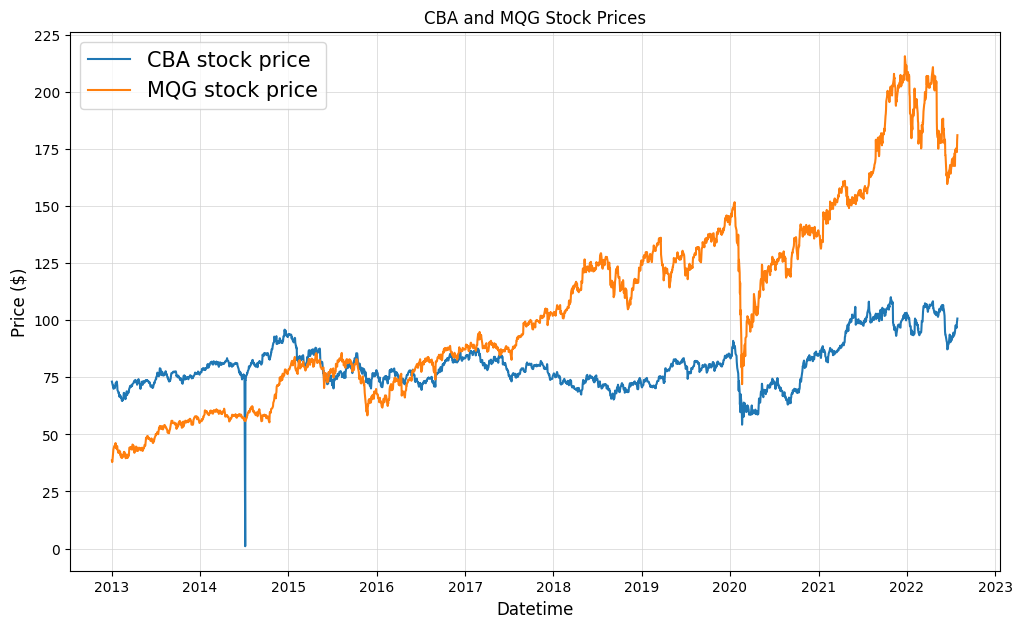

In [37]:
plt.plot(price_df.index, price_df['CBA'], label='CBA stock price')
plt.plot(price_df.index, price_df['MQG'], label='MQG stock price')
plt.title("CBA and MQG Stock Prices")
plt.legend(fontsize="15")

# Set labels and ticks
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.yticks(range(0, 250, 25))  # This will set ticks at intervals of 25 up to 250

# Design figure
fig = plt.gcf()  # Get the current figure
fig.set_size_inches(12, 7, forward=True)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)

## 4.2. Dependence of Log-Returns

In [38]:
# Linear correlation
np.corrcoef(df, rowvar = False)

array([[1.        , 0.08176529],
       [0.08176529, 1.        ]])

In [39]:
# Kendall's tau
log_ret_tau = stats.kendalltau(df['CBA'], df['MQG'])
log_ret_tau

SignificanceResult(statistic=np.float64(0.38801030996245117), pvalue=np.float64(4.0322349304386595e-179))

In [40]:
# Spearman's rho
log_ret_srho = stats.spearmanr(df, axis = 0)
log_ret_srho

SignificanceResult(statistic=np.float64(0.5338567747986649), pvalue=np.float64(7.024525769634955e-178))

In [41]:
# Required library
from pycop import empirical

# Empirical copula
em_cop = empirical(df.T.values)

# Non-parametric TDC estimates where k_l / n = 1% and k_u / n = 99%
em_cop.LTDC(0.01), em_cop.UTDC(0.99)

(np.float64(0.4144218814753419), np.float64(0.342312474098638))

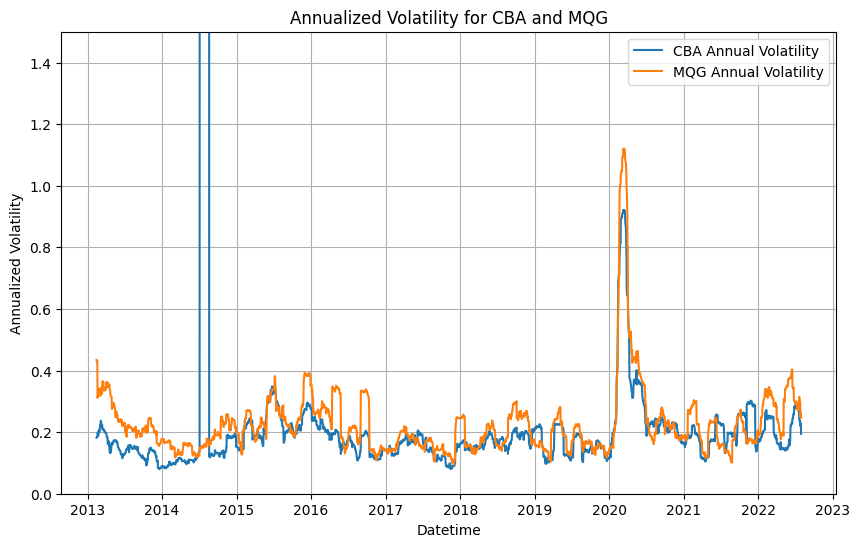

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your dataframe with log returns for CBA and MQG
# and it has a Date column which is already set as index or a datetime object.

# Step 1: Calculate the daily volatility (standard deviation)
daily_volatility_CBA = df['CBA'].rolling(window=30).std()  # 30-day rolling window for volatility
daily_volatility_MQG = df['MQG'].rolling(window=30).std()

# Step 2: Annualize the daily volatility
annual_volatility_CBA = daily_volatility_CBA * np.sqrt(250)  # Multiply by sqrt of trading days in a year
annual_volatility_MQG = daily_volatility_MQG * np.sqrt(250)

# Step 3: Plot the annual volatility for both CBA and MQG
plt.figure(figsize=(10, 6))
plt.plot(df.index, annual_volatility_CBA, label='CBA Annual Volatility')
plt.plot(df.index, annual_volatility_MQG, label='MQG Annual Volatility')

# Formatting the plot
plt.title('Annualized Volatility for CBA and MQG')
plt.xlabel('Datetime')
plt.ylabel('Annualized Volatility')
plt.ylim(0, 1.5)  # Set y-axis limit to range from 0 to 2
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Constructing results 

In [1236]:
# Copy the original dataframe
entire_risk_measure = portfolio_risk_measures.copy()

# Split 'risk_measure' into two columns 'VaR' and 'ES' as numerical values
entire_risk_measure[['VaR', 'ES']] = pd.DataFrame(entire_risk_measure['risk_measure'].tolist(), index=entire_risk_measure.index)

# Format the 'conf_level' to 0.XX
entire_risk_measure['conf_level'] = entire_risk_measure['conf_level'].apply(lambda x: f"{x:.2f}")

# Group the data by 'method', 'time_period', and 'conf_level' while keeping 'VaR' and 'ES' as floats
var_pivot = entire_risk_measure.pivot_table(
    index=['method'], 
    columns=['time_period', 'conf_level'], 
    values=['VaR']
)

# Apply formatting to the pivot table (rounding VaR and ES)
var_pivot = var_pivot.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)

# Generate LaTeX output
var_latex_code = var_pivot.to_latex(index=True, multicolumn=True, multirow=True)

# Print the LaTeX code
print(var_latex_code)

\begin{tabular}{lllllll}
\toprule
 & \multicolumn{6}{r}{VaR} \\
time_period & \multicolumn{3}{r}{1-day} & \multicolumn{3}{r}{10-day} \\
conf_level & 0.90 & 0.95 & 0.99 & 0.90 & 0.95 & 0.99 \\
method &  &  &  &  &  &  \\
\midrule
M1 & 3.73 & 5.05 & 6.87 & 11.01 & 14.46 & 20.94 \\
M2 & 2.86 & 4.24 & 8.09 & 7.26 & 12.54 & 24.32 \\
M3 & 3.11 & 5.19 & 6.65 & 6.91 & 11.01 & 23.88 \\
\bottomrule
\end{tabular}



In [1237]:
# Group the data by 'method', 'time_period', and 'conf_level' while keeping 'VaR' and 'ES' as floats
es_pivot = entire_risk_measure.pivot_table(
    index=['method'], 
    columns=['time_period', 'conf_level'], 
    values=['ES']
)

# Apply formatting to the pivot table (rounding VaR and ES)
es_pivot = es_pivot.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)

# Generate LaTeX output
es_latex_code = var_pivot.to_latex(index=True, multicolumn=True, multirow=True)

# Print the LaTeX code
print(es_latex_code)

\begin{tabular}{lllllll}
\toprule
 & \multicolumn{6}{r}{VaR} \\
time_period & \multicolumn{3}{r}{1-day} & \multicolumn{3}{r}{10-day} \\
conf_level & 0.90 & 0.95 & 0.99 & 0.90 & 0.95 & 0.99 \\
method &  &  &  &  &  &  \\
\midrule
M1 & 3.73 & 5.05 & 6.87 & 11.01 & 14.46 & 20.94 \\
M2 & 2.86 & 4.24 & 8.09 & 7.26 & 12.54 & 24.32 \\
M3 & 3.11 & 5.19 & 6.65 & 6.91 & 11.01 & 23.88 \\
\bottomrule
\end{tabular}



In [1231]:
# Copy the original dataframe
entire_risk_measure = portfolio_risk_measures.copy()

# Split 'risk_measure' into two columns 'VaR' and 'ES' as numerical values
entire_risk_measure[['VaR', 'ES']] = pd.DataFrame(entire_risk_measure['risk_measure'].tolist(), index=entire_risk_measure.index)

# Group the data by 'time_period', 'conf_level', and 'method' while keeping 'VaR' and 'ES' as floats
var_risk_measure = entire_risk_measure.pivot_table(
    index=['method'], 
    columns=['time_period', 'conf_level'], 
    values=['VaR']
)

# Apply formatting to the pivot table (rounding VaR and ES)
pivoted_entire_risk_measure = pivoted_entire_risk_measure.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)

# Generate LaTeX output
var_latex_code = pivoted_entire_risk_measure.to_latex(index=True, multicolumn=True, multirow=True)

# Print the LaTeX code
print(var_latex_code)

ValueError: Unknown format code 'f' for object of type 'str'

In [ ]:
# Detect index of Var value
loss_exceed = loss_scenario[(loss_scenario['cum_weight'] >= conf_level)]

# Compute VaR and ES
VaR = min(loss_exceed['loss'])
ES = sum((loss_exceed['loss'] - VaR) * loss_exceed['weight']) / (1 - conf_level) + VaR

# Store value
risk_measure = np.array([VaR, ES])